# Image Registration using VoxelMorph

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import time
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from skimage.transform import resize
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Losses

**Cross Correlation Loss:**
- Calculates the cross-correlation loss between two input tensors.
- Encourages the model to produce similar outputs to the ground truth.

**Smoothing Loss:**
- Measures smoothness by comparing neighboring pixel differences.
- Promotes visually coherent and less noisy predictions.

**Vox Morph Loss:**
- Combines cross-correlation loss and smoothing loss for voxel-based segmentation tasks.
- Encourages accurate segmentation and smooth transitions between neighboring voxels.

**Dice Score:**
- A common metric for segmentation evaluation.
- Compares the overlap and union of predicted and target tensors.
- Higher values indicate better segmentation performance.

In [2]:
def cross_correlation_loss(I, J, n=9):
    I = I.permute(0, 3, 1, 2).to(device)
    J = J.permute(0, 3, 1, 2).to(device)
    _, channels, _, _ = I.shape
    I2 = torch.mul(I, I).to(device)
    J2 = torch.mul(J, J).to(device)
    IJ = torch.mul(I, J).to(device)
    sum_filter = torch.ones((1, channels, n, n)).to(device)

    I_sum  = torch.conv2d(I,  sum_filter, padding=1, stride=1)
    J_sum  = torch.conv2d(J,  sum_filter, padding=1, stride=1)
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=1)
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=1)
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=1)
    win_size = n ** 2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size
    cc = cross * cross / (I_var * J_var + torch.finfo(torch.float32).eps)
    return torch.mean(cc)

def smoothing_loss(y_pred):
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def dice_score(pred, target):
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    return dice

## Load Data

**Overview of the FIRE Dataset**

The Fundus Image Registration (FIRE) Dataset, detailed at [FIRE Dataset](https://projects.ics.forth.gr/cvrl/fire/), is a specialized collection for image registration research in ophthalmology. It comprises 134 high-resolution fundus photographs, each with a resolution of 2912x2912 pixels. These images are divided into 45 retinal pairs, offering a diverse range of pathologies and anatomical features. This dataset provides a robust platform for evaluating the VoxelMorph framework's accuracy in aligning intricate details in retinal images, crucial for advanced medical image analysis.



In [3]:
!pip install -q requests py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.8 MB/s eta 0:00:00


In [4]:
import requests
import py7zr

# URL of the dataset
url = "https://projects.ics.forth.gr/cvrl/fire/FIRE.7z"

# Destination file name
output_file = "FIRE.7z"

# Downloading
response = requests.get(url)
with open(output_file, 'wb') as f:
    f.write(response.content)

# Extracting
with py7zr.SevenZipFile(output_file, mode='r') as archive:
    archive.extractall()

DATA_PATH = './FIRE/Images/'

In [11]:
class my_dataset(Dataset):
    def __init__(self, list_IDs):
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        fixed_image = torch.Tensor(resize(io.imread(DATA_PATH + ID + '_1.jpg'), (256, 256, 3)))
        moving_image = torch.Tensor(resize(io.imread(DATA_PATH + ID + '_2.jpg'), (256, 256, 3)))
        return fixed_image, moving_image


filename = list(set([x.split('_')[0] for x in os.listdir(DATA_PATH)]))

partition = {}
partition['train'], partition['validation'] = train_test_split(filename, test_size=0.33, random_state=42)

train_dataset = my_dataset(partition['train'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

val_dataset = my_dataset(partition['validation'])
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

## Model

### Unet

The `UNet` class represents the UNet architecture, a popular neural network model used for semantic segmentation tasks. It consists of contracting and expansive blocks, a bottleneck layer, and decoding layers.

- **Contracting Block** consists of two convolutional layers with batch normalization and ReLU activation. This block reduces the spatial dimensions of the input image.

- **Expansive Block** consists of convolutional layers, batch normalization, ReLU activation, and transposed convolutional layers. This block increases the spatial dimensions of the input image.

- **Final Block** consists of two convolutional layers with batch normalization and ReLU activation. This block is used to obtain the final segmentation output.

- **Crop and Concatenate** method crops the output of the contracting block and concatenates it with the corresponding layer from the expansive block. This operation helps preserve spatial information during the decoding process.


In [49]:
def conv_block(in_channels, out_channels, device, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ).to(device)

def conv_trans_block(in_channels, out_channels, device, kernel_size=3,  stride=2, padding=1, output_padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ).to(device)

class UNet(nn.Module):
    def __init__(self, in_channel, out_channel, device):
        super(UNet, self).__init__()

        self.encode = [
            nn.Sequential(conv_block(in_channel, 64, device), conv_block(64, 64, device)),
            nn.Sequential(nn.MaxPool2d(2, stride=2), conv_block(64, 128, device), conv_block(128, 128, device)),
            nn.Sequential(nn.MaxPool2d(2, stride=2), conv_block(128, 256, device), conv_block(256, 256, device)),
            nn.Sequential(nn.MaxPool2d(2, stride=2), conv_block(256, 512, device), conv_block(512, 512, device)),
        ]

        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            conv_block(512, 1024, device),
            conv_block(1024, 1024, device),
            conv_trans_block(1024, 512, device)
            )

        self.decode = [
            nn.Sequential(conv_block(1024, 512, device), conv_block(512, 512, device), conv_trans_block(512, 256, device)),
            nn.Sequential(conv_block(512, 256, device), conv_block(256, 256, device), conv_trans_block(256, 128, device)),
            nn.Sequential(conv_block(256, 128, device), conv_block(128, 128, device), conv_trans_block(128, 64, device)),
            nn.Sequential(conv_block(128, 64, device), conv_block(64, 64, device)),
        ]

        self.final_layer = nn.Sequential(
            conv_block(64, 32, device),
            conv_block(32, out_channel, device, kernel_size=1, padding=0)
        )


    def forward(self, x):

        connection = []
        for i in range(4):
          x = self.encode[i](x)
          connection.append(x)

        x = self.bottleneck(x)

        for i in range(4):
          x = torch.cat([connection[-(i+1)], x], dim=1)
          x = self.decode[i](x)

        return self.final_layer(x)

### Spatial Transformation

The `SpatialTransformation` class is a module used for image registration and spatial transformation. It provides methods for creating a meshgrid, repeating tensors, and interpolating pixel values.

- **Meshgrid**: Generates a 2D grid of coordinates (X and Y values) based on the input height and width.

- **Repeat**: Replicates a tensor multiple times along a specified axis.

- **Interpolate**: Performs bilinear interpolation to estimate pixel values at non-integer coordinates.

- **Forward**: Applies spatial transformation to a moving image using a deformation matrix. Computes new coordinates, performs interpolation, and returns the transformed image.

In [50]:
class SpatialTransformation(nn.Module):
    def __init__(self, device):
        super(SpatialTransformation, self).__init__()
        self.device = device

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])

        return x_t.to(self.device), y_t.to(self.device)

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)

        return x.to(self.device)

    def interpolate(self, im, x, y):
        im = F.pad(im, (0,0,1,1,1,1,0,0))

        batch_size, height, width, channels = im.shape

        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])

        return output


    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])

        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


### VoxelMorph

In [52]:
class VoxelMorph(nn.Module):
    def __init__(self, in_channels, device):
        super(VoxelMorph, self).__init__()
        self.unet = UNet(in_channels*2, 2, device).to(device)
        self.spatial_transform = SpatialTransformation(device).to(device)

    def forward(self, moving_image, fixed_image):
        x = torch.cat([moving_image, fixed_image], dim=3).permute(0,3,1,2)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image

## Train

In [53]:
num_epochs = 3
num_channels = train_dataset[0][0].shape[2]
voxelmorph = VoxelMorph(num_channels, device).to(device)
optimizer = optim.SGD(voxelmorph.parameters(), lr=1e-4, momentum=0.99)

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_dice_score, val_loss, val_dice_score = 0, 0, 0, 0
    num_train_batches, num_val_batches = len(train_loader), len(val_loader)

    # Training Phase
    voxelmorph.train()
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training')
    for batch_fixed, batch_moving in train_loader_tqdm:
        batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)

        optimizer.zero_grad()
        registered_image =  voxelmorph(batch_moving, batch_fixed)
        loss1 = cross_correlation_loss(registered_image, batch_fixed)
        loss2 = smoothing_loss(registered_image)
        loss = (-1.0 * loss1) + (0.01 * loss2)
        train_loss += loss.item()
        train_dice_score += dice_score(registered_image, batch_fixed)

        loss.backward()
        optimizer.step()

        # Update progress bar
        train_loader_tqdm.set_postfix(train_loss=train_loss / (train_loader_tqdm.n + 1))
        train_loader_tqdm.update()

    train_loss /= num_train_batches
    train_dice_score /= num_train_batches

    # Validation Phase
    voxelmorph.eval()
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation')
    with torch.no_grad():
        for batch_fixed, batch_moving in val_loader_tqdm:
            batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)

            registered_image =  voxelmorph(batch_moving, batch_fixed)
            loss1 = cross_correlation_loss(registered_image, batch_fixed)
            loss2 = smoothing_loss(registered_image)
            loss = (-1.0 * loss1) + (0.01 * loss2)
            val_loss += loss.item()
            val_dice_score += dice_score(registered_image, batch_fixed)

            # Update progress bar
            val_loader_tqdm.set_postfix(val_loss=val_loss / (val_loader_tqdm.n + 1))
            val_loader_tqdm.update()

    val_loss /= num_val_batches
    val_dice_score /= num_val_batches

    # Print epoch summary
    epoch_duration = (time.time() - epoch_start_time) / 60
    print(f"Epoch {epoch + 1}/{num_epochs} - Duration: {epoch_duration:.2f} mins - Train Loss: {train_loss:.3f}, Train DICE: {train_dice_score:.3f}, Val Loss: {val_loss:.3f}, Val DICE: {val_dice_score:.3f}")
    

Epoch 1/3 - Validation: 100%|██████████| 45/45 [02:10<00:00,  2.90s/it, val_loss=-.0372]


Epoch 1/3 - Duration: 6.60 mins - Train Loss: -1.309, Train DICE: 0.283, Val Loss: -0.045, Val DICE: 0.025


Epoch 2/3 - Validation: 100%|██████████| 45/45 [02:16<00:00,  3.03s/it, val_loss=-.0108]


Epoch 2/3 - Duration: 6.68 mins - Train Loss: 0.009, Train DICE: 0.013, Val Loss: -0.013, Val DICE: 0.012


Epoch 3/3 - Validation: 100%|██████████| 45/45 [02:13<00:00,  2.97s/it, val_loss=0.00246]

Epoch 3/3 - Duration: 6.64 mins - Train Loss: 0.017, Train DICE: 0.010, Val Loss: 0.003, Val DICE: 0.010


Seems **Vanishing Gradient** is happening. After 2 epochs loss become 0 and model can't learn. (*Loss functions were implemented and I justed called them*)
Also each epoch takes around 7 mins.

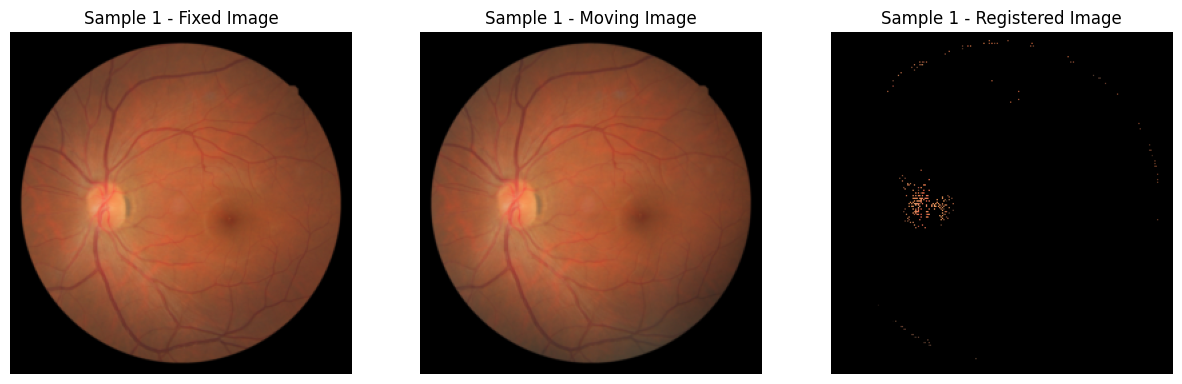

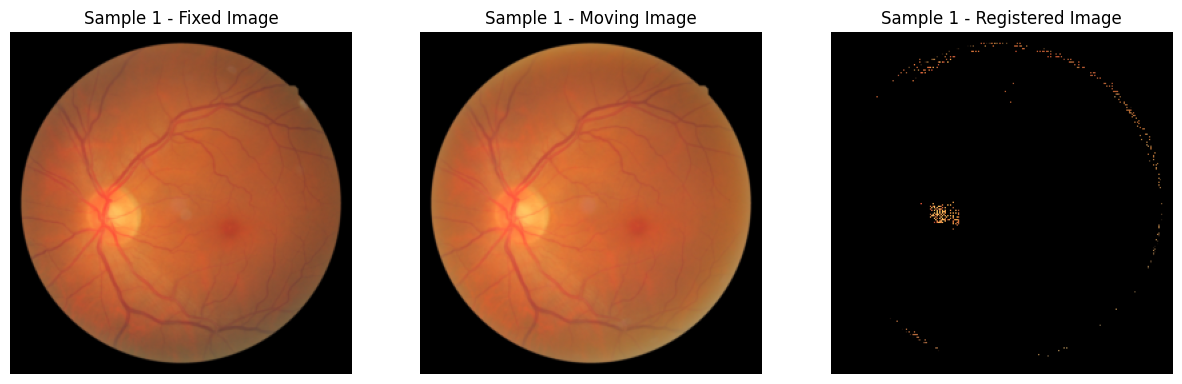

In [54]:
def plot_samples(batch_fixed, batch_moving, registered_image, k):
    """
    Plot k samples from batch_fixed, batch_moving, and registered_image.
    """
    fig, axs = plt.subplots(k, 3, figsize=(15, 5 * k))

    if not isinstance(batch_fixed, list):
        batch_fixed = [batch_fixed]
    if not isinstance(batch_moving, list):
        batch_moving = [batch_moving]
    if not isinstance(registered_image, list):
        registered_image = [registered_image]

    if k == 1:
      axs[0].imshow(batch_fixed[0].cpu().squeeze(), cmap='gray')
      axs[0].set_title(f'Sample {1} - Fixed Image')
      axs[0].axis('off')

      axs[1].imshow(batch_moving[0].cpu().squeeze(), cmap='gray')
      axs[1].set_title(f'Sample {1} - Moving Image')
      axs[1].axis('off')

      axs[2].imshow(registered_image[0].cpu().squeeze(), cmap='gray')
      axs[2].set_title(f'Sample {1} - Registered Image')
      axs[2].axis('off')
    else:
      for i in range(k):
          # Plot fixed image
          if i < len(batch_fixed):
              axs[i, 0].imshow(batch_fixed[i].cpu().squeeze(), cmap='gray')
              axs[i, 0].set_title(f'Sample {i+1} - Fixed Image')
              axs[i, 0].axis('off')

          # Plot moving image
          if i < len(batch_moving):
              axs[i, 1].imshow(batch_moving[i].cpu().squeeze(), cmap='gray')
              axs[i, 1].set_title(f'Sample {i+1} - Moving Image')
              axs[i, 1].axis('off')

          # Plot registered image
          if i < len(registered_image):
              axs[i, 2].imshow(registered_image[i].cpu().squeeze(), cmap='gray')
              axs[i, 2].set_title(f'Sample {i+1} - Registered Image')
              axs[i, 2].axis('off')

    plt.show()


voxelmorph.eval()
for batch_fixed, batch_moving in train_loader:
  batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
  with torch.no_grad():
    registered_image =  voxelmorph(batch_moving, batch_fixed)

  plot_samples(batch_fixed, batch_moving, registered_image, k=1)
  break

for batch_fixed, batch_moving in val_loader:
  batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
  with torch.no_grad():
    registered_image =  voxelmorph(batch_moving, batch_fixed)

  plot_samples(batch_fixed, batch_moving, registered_image, k=1)
  break